In [1]:
from modules.data.temporal import *
from modules.data.mixed import *
from modules.utils.pso import *
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [2]:
dataset = TemporalChunkedDataset("data/time_series/indrani_zeta_ca_no_zeroes.pickle")


torch.Size([2000, 2])
(1000, 2000, 2)


In [3]:
print(dataset[0])

rates, input, output = dataset[0]
print(input.size())
print(output.size())

(tensor([2.4733e-03, 4.1428e+00, 5.9924e+03, 4.9297e+00, 8.1268e-03],
       dtype=torch.float64), tensor([[0.1151, 0.2705],
        [0.1161, 0.2730],
        [0.1173, 0.2754],
        [0.1184, 0.2778]], dtype=torch.float64), tensor([[0.1161, 0.2730],
        [0.1173, 0.2754],
        [0.1184, 0.2778],
        [0.1194, 0.2802]], dtype=torch.float64))
torch.Size([4, 2])
torch.Size([4, 2])


In [43]:
full_seq_dataset = TemporalDataset("data/time_series/indrani_zeta_ca_no_zeroes_2500.pickle", min_max_scale=True)


torch.Size([2000, 2])


torch.Size([1999, 2])
tensor([1333.6679,  223.0429], dtype=torch.float64)


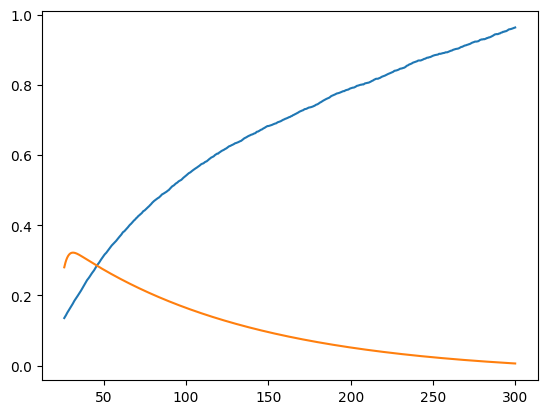

In [44]:
rates, input, output = full_seq_dataset[30]
print(input.size())
print(torch.sum(input, dim=0))
plt.plot(full_seq_dataset.times[:-1], input[:,:].numpy())

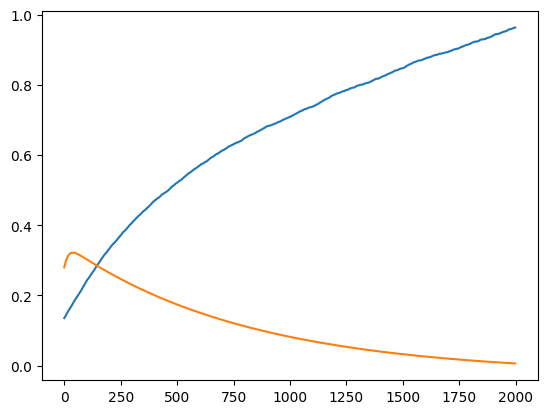

In [45]:
plt.plot(input.numpy())

In [ ]:
def combine_pickles_into_bigger_pickle(path1, path2):
    

In [53]:
# find 4 time points
time_points = [10,250,750,1750]
# process these into a new dataset, and then train
for t in time_points:
    data = generate_static_dataset(full_seq_dataset,t)
    data.write_to_csv("data/static/indrani_zeta_ca_t" +str(t) + ".csv")

In [56]:
def plot_trajectory_with_confidence_intervals(trajectories, confidence=0.68):
    num_trajectories, trajectory_length, feature_dim = trajectories.shape

    # Calculate mean and standard deviation for each time step
    mean_trajectory = np.mean(trajectories, axis=0)
    std_trajectory = np.std(trajectories, axis=0)
    # print(std_trajectory)

    # Calculate confidence intervals
    z_score = 1  # For 97% confidence interval (adjust as needed)
    lower_bound = mean_trajectory - z_score * std_trajectory #/ np.sqrt(num_trajectories)
    upper_bound = mean_trajectory + z_score * std_trajectory #/ np.sqrt(num_trajectories)
    # print(lower_bound)
    # print(upper_bound)
    # Plot mean trajectory
    time_points = np.arange(trajectory_length)
    plt.plot(time_points, mean_trajectory, label='Mean Trajectory')

    # Plot confidence intervals for each feature dimension
    for f in range(feature_dim):
        plt.fill_between(time_points, lower_bound[:, f], upper_bound[:, f],
                        alpha=0.3, label='2 Standard Deviations')

    # Set plot labels and title
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Trajectory with Confidence Intervals')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

(2500, 2000, 2)


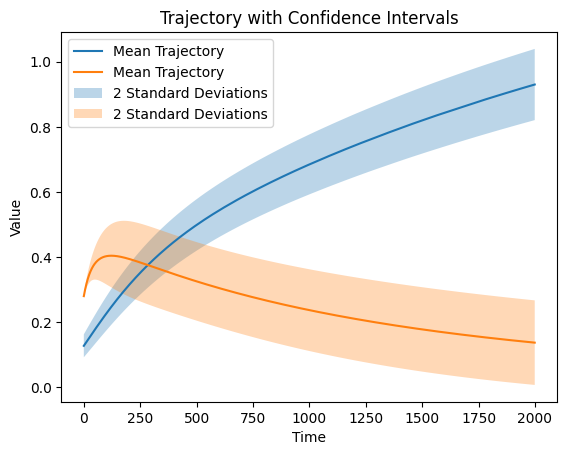

In [61]:
forPlotting = []
for output in full_seq_dataset.outputs:
    forPlotting.append(output.numpy())
forPlotting = np.array(forPlotting)
print(forPlotting.shape)
plot_trajectory_with_confidence_intervals(forPlotting)

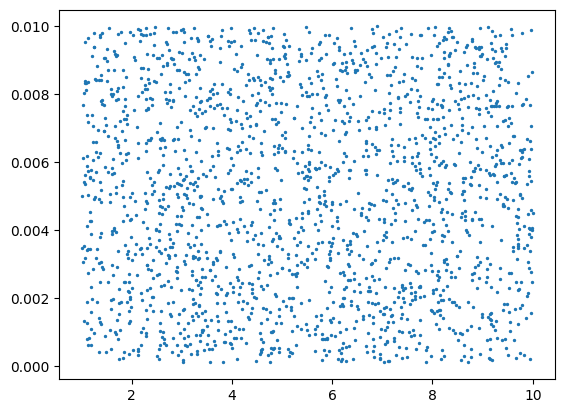

In [60]:
x = [r[3].numpy() for r in full_seq_dataset.rates]
y = [r[4].numpy() for r in full_seq_dataset.rates]
plt.scatter(x[:int(0.8*(len(x)))],y[:int(0.8*(len(x)))],s=2)

In [67]:
from sklearn.neighbors import NearestNeighbors

def find_nearest_neighbors(query_trajectory, trajectories, k):
    # Flatten the trajectories for nearest neighbor search
    flattened_trajectories = np.reshape(trajectories, (len(trajectories), -1))

    # Create a NearestNeighbors instance and fit the data
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(flattened_trajectories)

    # Reshape the query trajectory for nearest neighbor search
    query_flattened = np.reshape(query_trajectory, (1, -1))

    # Find the indices of nearest neighbors
    _, indices = nn.kneighbors(query_flattened)

    return indices.flatten()

In [71]:
find_nearest_neighbors(forPlotting[0], forPlotting, 5)

array([   0, 1290,  552,  901, 1079])

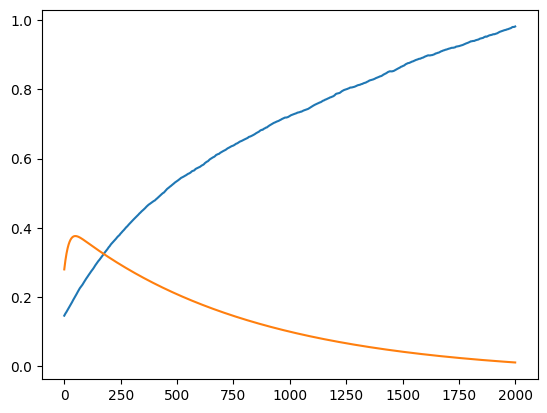

In [74]:
plt.plot(forPlotting[0])

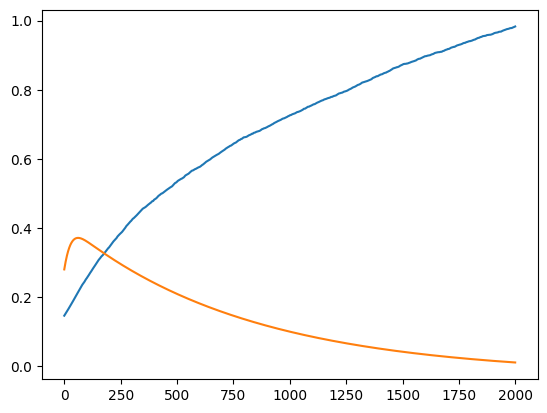

In [77]:
plt.plot(forPlotting[1290])

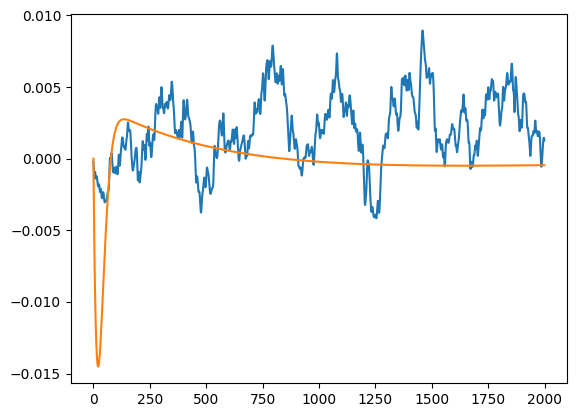

In [78]:
plt.plot(forPlotting[1290] - forPlotting[0])

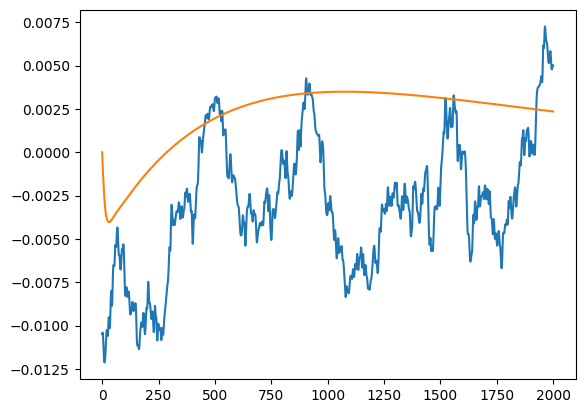

In [81]:
plt.plot(forPlotting[0] - forPlotting[552])

In [72]:
print(full_seq_dataset.rates[1290])

tensor([6.1361e-03, 9.6262e+00, 7.1413e+03, 5.0515e+00, 9.1834e-03],
       dtype=torch.float64)


In [73]:
print(full_seq_dataset.rates[0])

tensor([5.7336e-03, 6.0856e+00, 9.8358e+03, 7.1113e+00, 9.1029e-03],
       dtype=torch.float64)


#### PSO

In [ ]:
 # pso for hard trained model
l3Dataset100k = ABMDataset("data/static/l3p_100k.csv", root_dir="data/", standardize=True, norm_out=True)
sgModel = tc.load("model/l3p_100k_large_batch_normed.pt")
wt = np.loadtxt("pso/gmm_weight/l3p_t3.txt")
# wt = np.identity(sgModel.output_size)
# # print(wt)
x = np.zeros(sgModel.input_size)
y = np.array([12.4509,  6.9795, 9.06247, 93.9796, 31.9489, 84.5102, 53.8117, 72.7715, 47.3049])


estimates = []
for i in range(10):   
    gcost, gbest = StewartPSO(sgModel, y, wt, n_steps=50, n_particles=500, dataset=l3Dataset100k, standardize=False, normalize_out=True, batch=True)
    estimates.append(gbest)

estimates = np.array(estimates)
print("Surrogate Estimates:")
print(estimates)
print("Means:",np.mean(estimates,axis=0))
print("Var:",np.var(estimates, axis=0))
# from BioNetGMMFit:
bngmm_est = "data/BNGMMFit/model_estimates.csv"
print("BioNetGMMFit Estimates 200 Particles, 40 steps:")
data = np.genfromtxt(bngmm_est, delimiter=",", skip_header=True)
np.set_printoptions(suppress=True)
print("Means:", np.mean(data, axis=0))
print("Var:", np.var(data, axis=0))